In [1]:
pip install -q graphlearning

     |████████████████████████████████| 51 kB 617 kB/s 
     |████████████████████████████████| 646 kB 47.3 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 


In [2]:
import graphlearning as gl
import numpy as np
from numpy.linalg import inv
from scipy import sparse, linalg
from scipy.special import softmax
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
import time

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


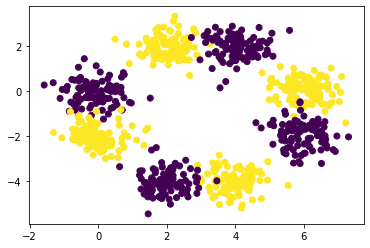

In [3]:
#Load data, labels
n=100 
np.random.seed(12) #set random seed
std = 0.5
data1 = std*np.random.randn(n,2) #upper left
data2 = std*np.random.randn(n,2) #top left
data2[:,0] += 2
data2[:,1] += 2
data3 = std*np.random.randn(n,2) #top right
data3[:,0] += 4
data3[:,1] += 2
data4 = std*np.random.randn(n,2) #upper right
data4[:,0] += 6
data5 = std*np.random.randn(n,2) #lower right
data5[:,0] += 6
data5[:,1] -= 2
data6 = std*np.random.randn(n,2) #bottom right
data6[:,0] += 4
data6[:,1] -= 4
data7 = std*np.random.randn(n,2) #bottom left
data7[:,0] += 2
data7[:,1] -= 4
data8 = std*np.random.randn(n,2) #lower left
data8[:,1] -= 2
data = np.vstack([data1,data2,data3,data4,data5,data6,data7,data8])
labels = np.hstack([np.zeros(n),np.ones(n),np.zeros(n),np.ones(n),np.zeros(n),
                    np.ones(n),np.zeros(n),np.ones(n)]).astype('int')
np.random.seed()

#Build a knn weight matrix and plot the dataset
W = gl.knn_weight_matrix(15, data)
plt.scatter(data[:,0],data[:,1], c=labels)

In [4]:
def acquisition_function(C_a, H_inv, gamma_inv, V, candidate_inds, u, method='vopt', plot=False, gamma=0.1):
  assert method in ['uncertainty','vopt','mc','mcvopt','bounds']

  #calculate uncertainty terms
  num_classes = u.shape[1]
  u_probs = softmax(u[candidate_inds], axis=1)
  one_hot_predicted_labels = np.eye(num_classes)[np.argmax(u[candidate_inds], axis=1)]
  unc_terms = np.linalg.norm((u_probs - one_hot_predicted_labels), axis=1)

  if method == 'uncertainty':
    return unc_terms

  Cavk = C_a @ V[candidate_inds,:].T
  col_norms = np.linalg.norm(Cavk, axis=0)
  diag_terms = (gamma**2. + np.array([np.inner(V[k,:], Cavk[:, i]) for i,k in enumerate(candidate_inds)]))

  if method == 'vopt':
    return col_norms**2. / diag_terms

  if method == 'mc':
    return unc_terms * col_norms / diag_terms

  if method == 'mcvopt':
    return unc_terms * col_norms **2. / diag_terms
  
  else:
    return np.diag(V[candidate_inds]@H_inv@gamma_inv@H_inv@V[candidate_inds].T)/(1+np.diag(V[candidate_inds]@H_inv@V[candidate_inds].T))

def update_H(V, H_inv, new_ind):
    new_vector = V[new_ind][:,np.newaxis]
    H_inv -= (H_inv@new_vector@new_vector.T@H_inv)/(1+(new_vector.T@H_inv@new_vector))
    return H_inv

def update_C_a(C_a, V, Q, gamma=0.1):
  for k in Q:
    vk = V[k]
    Cavk = C_a @ vk
    ip = np.inner(vk, Cavk)
    C_a -= np.outer(Cavk, Cavk)/(gamma**2. + ip)
  return C_a

In [43]:
def active_learning_loop(W, evals, evecs, train_ind, labels, num_iter, method, L, k=8, gamma=0.1, mu=0.01):
  assert method in ['random','uncertainty','vopt','mc','mcvopt','bounds','signals']
  accuracy = np.array([])
  C_a = np.linalg.inv(np.diag(evals) + evecs[train_ind,:].T @ evecs[train_ind,:] / gamma**2.) # M by M covariance matrix
  gamma_inv = np.diag(1/((mu*evals+1)*(mu*evals+1)-1))
  H_inv = gamma_inv ##incorrect if set to gamma
  L_k = L
  for i in range(k):
    L_k = L_k*L #compute L^k

  for i in range(num_iter+1):
    if i>0:
      unlabeled_ind = np.delete(np.arange(len(labels)), train_ind)
      if method is 'random':
        obj_vals = np.ones(len(unlabeled_ind))*(len(unlabeled_ind)/len(labels))
        train_ind = np.append(train_ind, np.random.choice(unlabeled_ind))
      elif method is 'signals':
        idx = np.ones(L.shape[0], dtype=bool)
        idx[train_ind] = False
        reduced_L = L_k[idx,:]
        reduced_L = reduced_L[:,idx]
        reduced_evals, reduced_evecs = sparse.linalg.eigsh(reduced_L, k=1, which='LM', sigma=0)
        reduced_evals = reduced_evals.real
        reduced_evecs = reduced_evecs.real
        evecs = np.zeros(L.shape[0])
        evecs[unlabeled_ind] = reduced_evecs.reshape((len(unlabeled_ind),))
        obj_vals = reduced_evecs.reshape((len(unlabeled_ind),))**2
        print(obj_vals.min(), obj_vals.max())
        new_train_ind = np.argmax(evecs**2)
        train_ind = np.append(train_ind, new_train_ind)
      else:
        obj_vals = acquisition_function(C_a, H_inv, gamma_inv, evecs, unlabeled_ind, u, method=method, gamma=gamma)
        new_train_ind = unlabeled_ind[np.argmax(obj_vals)]
        C_a = update_C_a(C_a, evecs, [new_train_ind], gamma=gamma)
        H_inv = update_H(evecs, H_inv, new_train_ind)
        train_ind = np.append(train_ind, new_train_ind)

      #Plot
      fig, ax = plt.subplots()    
      p = ax.scatter(data[unlabeled_ind,0], data[unlabeled_ind,1], c=obj_vals)
      ax.scatter(data[train_ind,0], data[train_ind,1], c='r', marker='^', s=100)
      ax.set_title(method.upper())
      plt.colorbar(p, ax=ax)
      plt.savefig(f'{method}')
      plt.show()

    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    laplace_labels = np.argmax(u, axis=1)
    laplace_acc = gl.accuracy(labels, laplace_labels, len(train_ind))
    print('Laplace: %d labels, %.3f'%(len(train_ind),laplace_acc))
    accuracy = np.append(accuracy, laplace_acc)

  return train_ind, accuracy

In [44]:
L=gl.graph_laplacian(W) #construct the graph laplacian
evals, evecs = sparse.linalg.eigs(L,k=200, which='SM')
evecs = evecs.real  
evals = evals.real
#evals[0] = 1e-6
evals += 1e-4

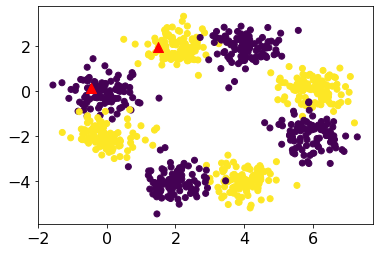

Laplace: 2 labels, 49.875


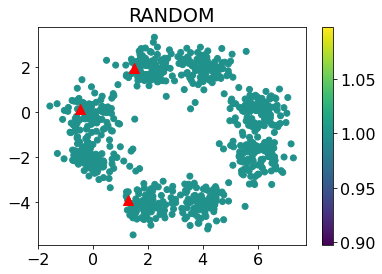

Laplace: 3 labels, 51.568


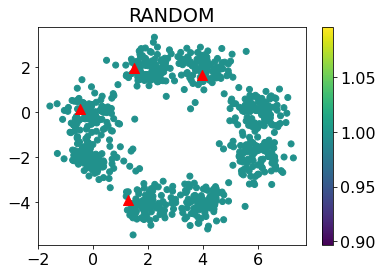

Laplace: 4 labels, 61.432


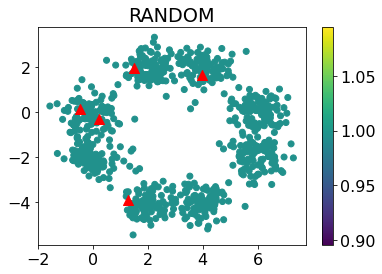

Laplace: 5 labels, 61.384


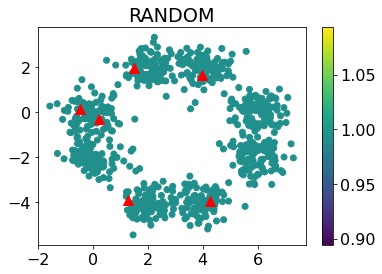

Laplace: 6 labels, 73.426


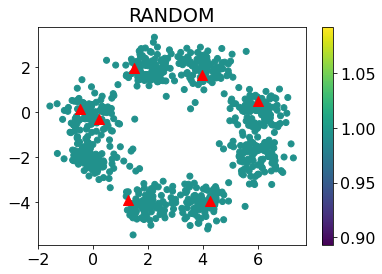

Laplace: 7 labels, 73.897


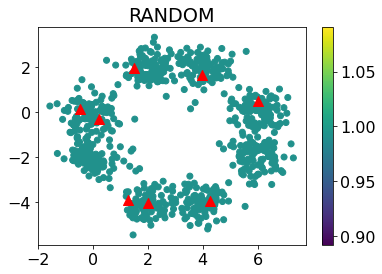

Laplace: 8 labels, 73.485


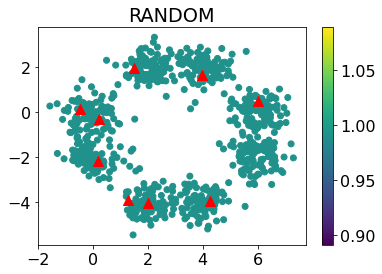

Laplace: 9 labels, 84.197


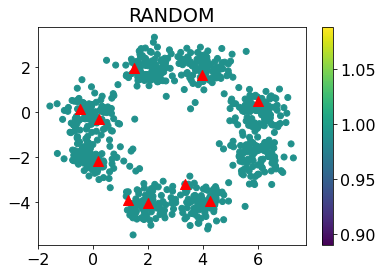

Laplace: 10 labels, 83.797


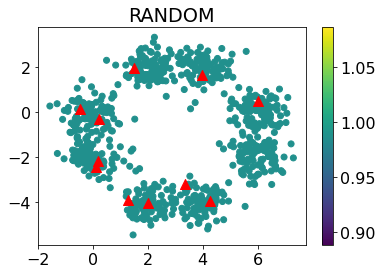

Laplace: 11 labels, 84.030


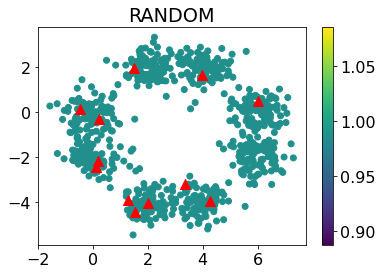

Laplace: 12 labels, 84.137


In [45]:
# Set initial labeled set
np.random.seed(2)
train_ind = gl.randomize_labels(labels, 1)
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)
np.random.seed()
plt.scatter(data[:,0], data[:,1], c=labels)
plt.scatter(data[train_ind,0], data[train_ind,1], c= 'r', marker='^', s=100)
plt.show()

# Run Random Test
train_ind, rand_acc = active_learning_loop(W, evals, evecs, train_ind, labels, 10, 'random', L)

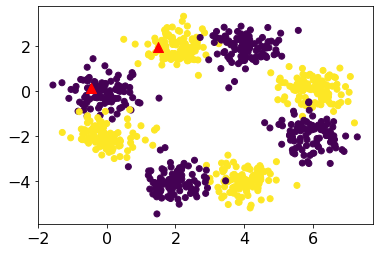

Laplace: 2 labels, 49.875


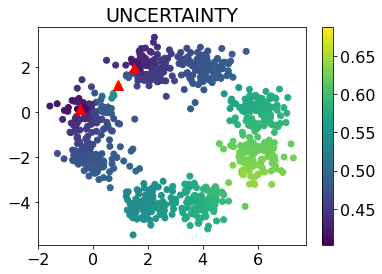

Laplace: 3 labels, 49.561


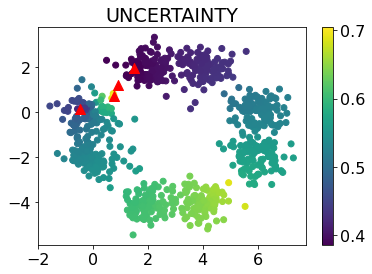

Laplace: 4 labels, 49.749


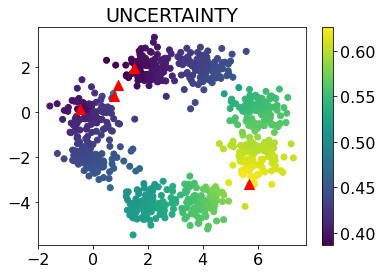

Laplace: 5 labels, 49.686


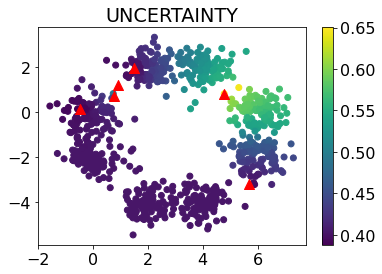

Laplace: 6 labels, 61.587


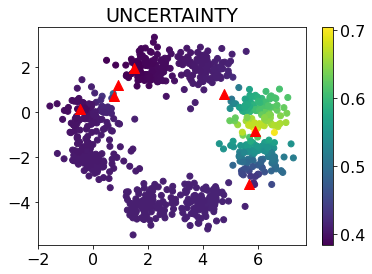

Laplace: 7 labels, 50.441


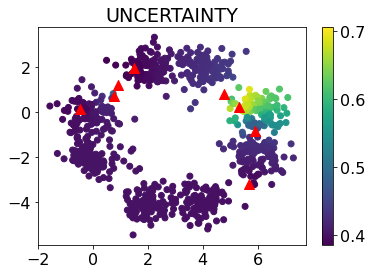

Laplace: 8 labels, 58.586


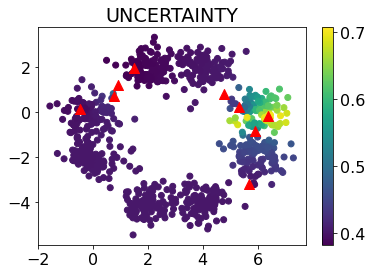

Laplace: 9 labels, 60.936


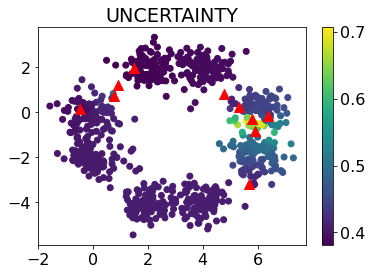

Laplace: 10 labels, 61.392


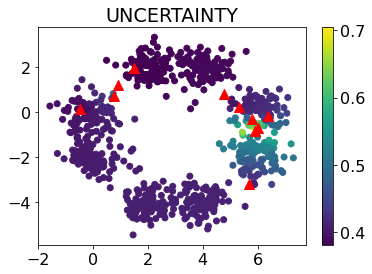

Laplace: 11 labels, 61.343


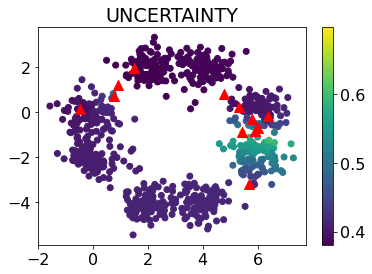

Laplace: 12 labels, 61.421


In [46]:
# Set initial labeled set
np.random.seed(2)
train_ind = gl.randomize_labels(labels, 1)
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)
np.random.seed()
plt.scatter(data[:,0], data[:,1], c=labels)
plt.scatter(data[train_ind,0], data[train_ind,1], c= 'r', marker='^', s=100)
plt.show()

# Run Uncertainty Sampling Test
train_ind, unc_acc = active_learning_loop(W, evals, evecs, train_ind, labels, 10, 'uncertainty', L)

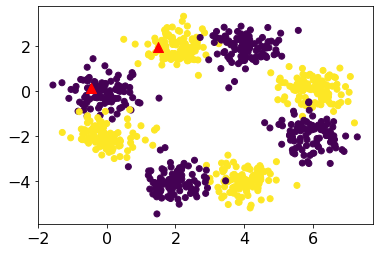

Laplace: 2 labels, 49.875


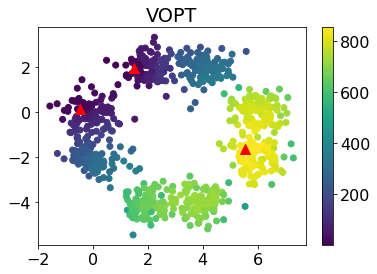

Laplace: 3 labels, 49.686


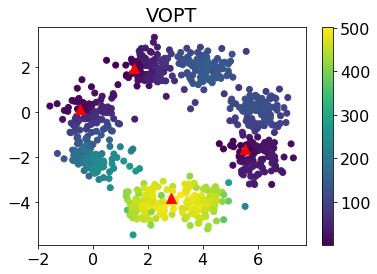

Laplace: 4 labels, 49.623


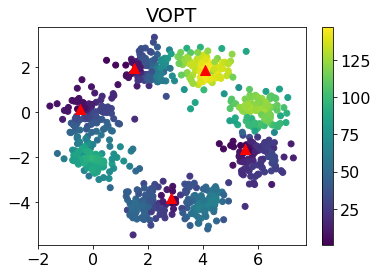

Laplace: 5 labels, 61.384


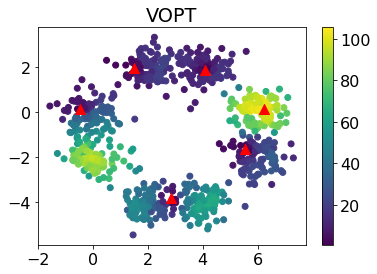

Laplace: 6 labels, 73.426


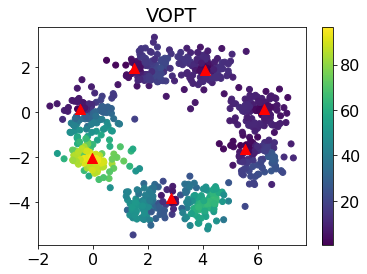

Laplace: 7 labels, 85.246


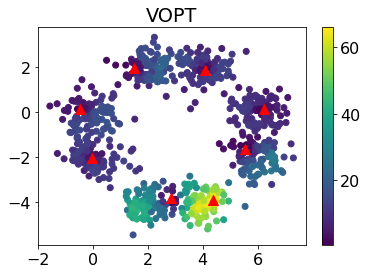

Laplace: 8 labels, 95.581


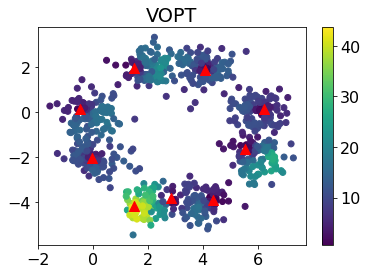

Laplace: 9 labels, 95.575


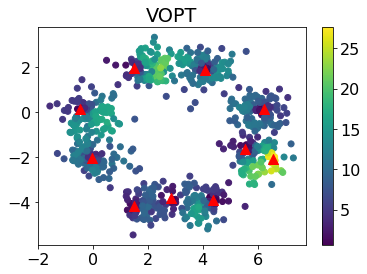

Laplace: 10 labels, 95.443


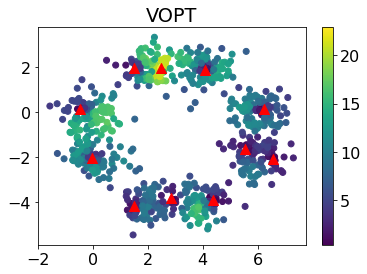

Laplace: 11 labels, 95.564


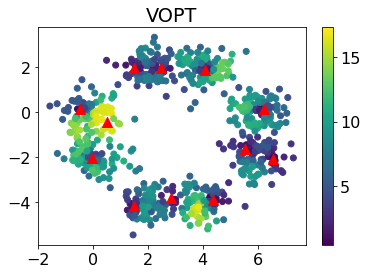

Laplace: 12 labels, 94.162


In [47]:
# Set initial labeled set
np.random.seed(2)
train_ind = gl.randomize_labels(labels, 1)
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)
np.random.seed()
plt.scatter(data[:,0], data[:,1], c=labels)
plt.scatter(data[train_ind,0], data[train_ind,1], c= 'r', marker='^', s=100)
plt.show()

# Run VOPT Test
train_ind, vopt_acc = active_learning_loop(W, evals, evecs, train_ind, labels, 10, 'vopt', L)

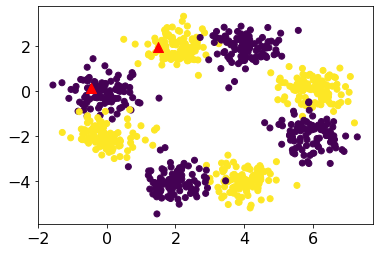

Laplace: 2 labels, 49.875
2.62974628504385e-11 0.013129858012694036


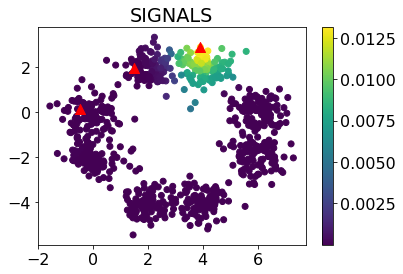

Laplace: 3 labels, 61.857
1.5108487666408922e-10 0.013641132837254471


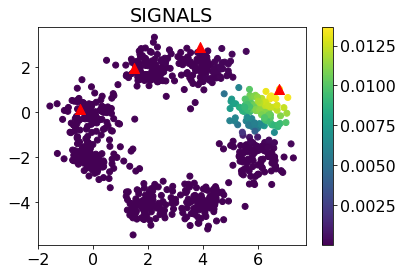

Laplace: 4 labels, 61.307
2.9420921581547492e-12 0.012702135787126544


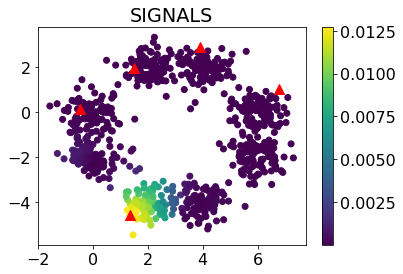

Laplace: 5 labels, 61.258
5.977921642718615e-13 0.01300123027616803


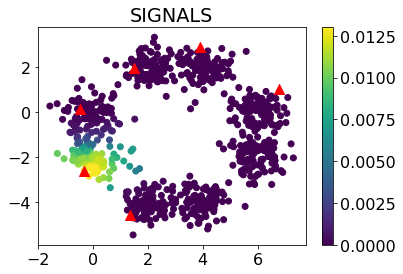

Laplace: 6 labels, 70.781
1.9050431770055986e-10 0.025942866250993072


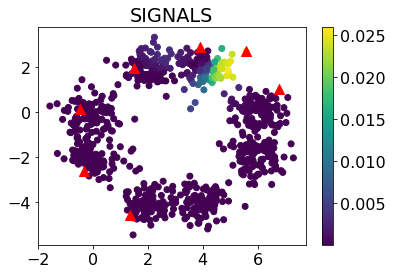

Laplace: 7 labels, 71.122
8.969400295333936e-15 0.010659042868226675


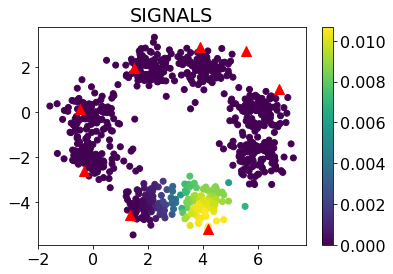

Laplace: 8 labels, 84.091
3.0010408598173927e-12 0.02327104342916847


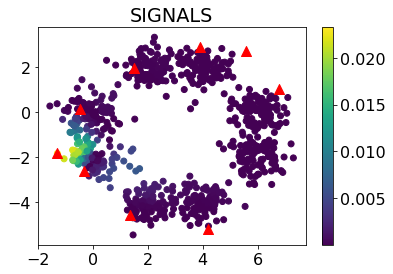

Laplace: 9 labels, 84.956
4.594034869985725e-12 0.034340133122281465


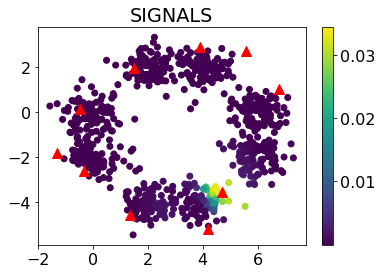

Laplace: 10 labels, 84.304
5.960563631897202e-13 0.027366056049531188


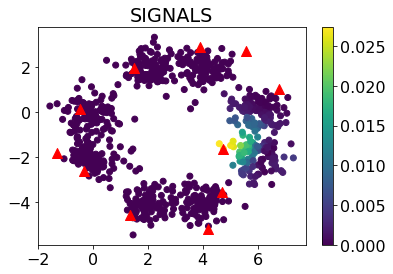

Laplace: 11 labels, 96.324
3.4131271984529516e-13 0.01877687860873032


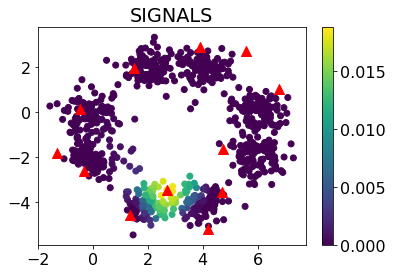

Laplace: 12 labels, 97.589


In [48]:
# Set initial labeled set
np.random.seed(2)
train_ind = gl.randomize_labels(labels, 1)
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)
np.random.seed()
plt.scatter(data[:,0], data[:,1], c=labels)
plt.scatter(data[train_ind,0], data[train_ind,1], c= 'r', marker='^', s=100)
plt.show()

# Run Graph Signals Test
train_ind, signals_acc = active_learning_loop(W, evals, evecs, train_ind, labels, 10, 'signals', L)

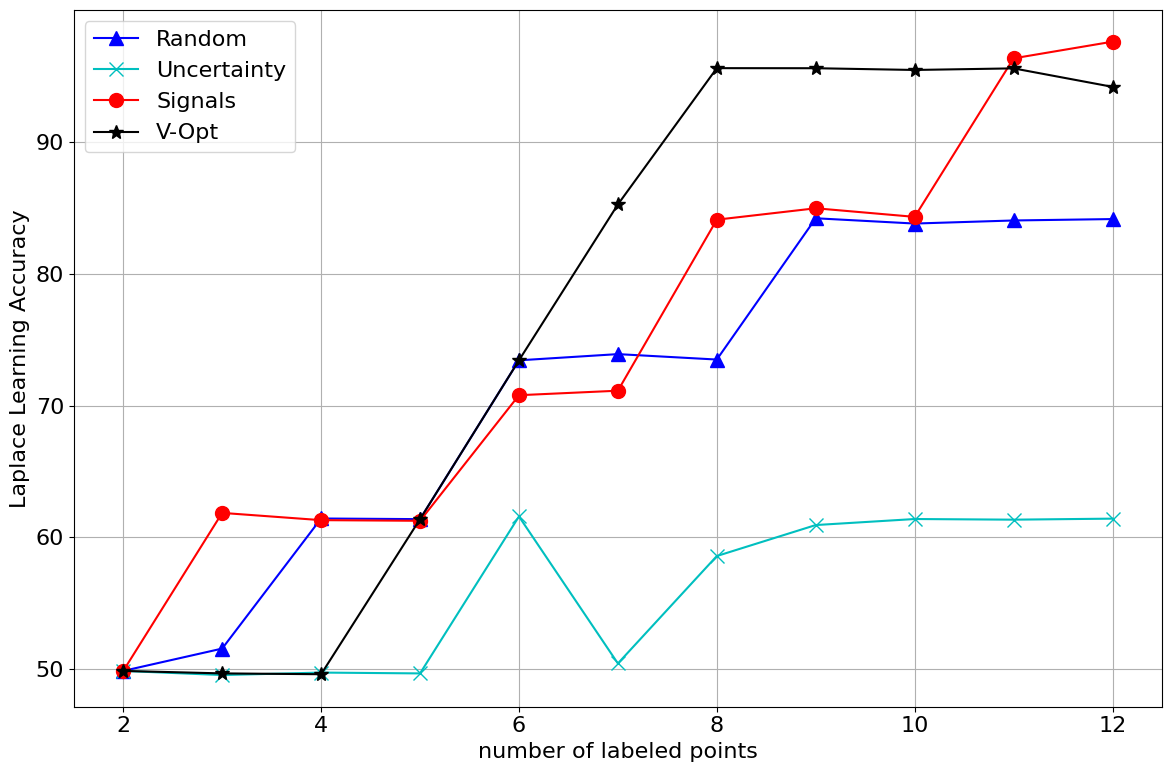

rand: 84.197 unc: 61.587 signals: 97.589 vopt: 95.581


In [49]:
plt.figure(figsize=(12, 8), dpi=100)
matplotlib.rcParams.update({'font.size': 16})
num_train = np.arange(2,13)
styles = ['^b-','or-','xc-', '*k-']
plt.plot(num_train, rand_acc, styles[0], markersize=10, label='Random')
plt.plot(num_train, unc_acc, styles[2], markersize=10, label='Uncertainty')
# plt.plot(num_train, erm_acc, 'yo-', markersize=10, label='ERM')
plt.plot(num_train, signals_acc, styles[1], markersize=10, label='Signals')
plt.plot(num_train, vopt_acc, styles[-1], markersize=10, label='V-Opt')
# plt.plot(num_train, bound_acc[-length:], 'rs-', markersize=10, label='Bound')
plt.xlabel('number of labeled points')
plt.ylabel('Laplace Learning Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Laplace.png')
plt.show()
print("rand: %.3f"%rand_acc.max(), "unc: %.3f"%unc_acc.max(), "signals: %.3f"%signals_acc.max(), "vopt: %.3f"%vopt_acc.max())